# Predicting On-time Delivery of Online Purchases
## AAI-510 Team 7 Final Project

Team 7:  Ken Devoe, Tyler Foreman, Geoffrey Fadera

University of San Diego, Applied Artificial Intelligence

Date:  June 24, 2024

GitHub Repository: https://github.com/kdevoe/aai510-group7

## Business Problem Statement and Approach

**Business Understanding**

SevenSeas, Inc. is an online retailer, selling a broad catalog of products through various e-commerce channels.  As a company operating at a global scale, SevenSeas ships direct to customers all over the world by air, sea and land.  Recently, there has been an uptick in customer complaints due to shipments not being delivered on time.  This has resulted in unhappy customers that have posted negative reviews online as well as an increase in returns and requests for refunds.

Company leadership has flagged this as an urgent issue to resolve.  Our data science team has been tasked to develop a method to better predict on-time delivery of products based on a combination of characteristics that describe the shipping medium and customer profile.  These predictions will need to be made prior to the package being prepared for shipment.  To facilitate this, the team has compiled a dataset of key characteristics that are known at the time of purchase.  These predictions will enable SevenSeas to adjust the shipping methods for those packages that are determined to be at risk of delayed shipment using standard methods and ensure that on-time delivery is improved.

The key objectives of this project are:

- Develop a machine learning model that can predict whether a package will be delivered on-time based on a set of characteristics known at the time of purchase.
- Determine which features of the shipping medium are contributing most to predicting delayed deliveries
 

**Approach**

Based on the team's business understanding of the business challenge and dataset, it was determined that the best way to frame this problem was as a supervised learning task to perform binary classification.  That is, the model would be trained on the labeled dataset to make binary predictions as to whether the shipment would be on-time (1) or late (0).  As such, the team seeks to experiment with several candidate classical machine learning model architectures that are suited for the binary classification task, evaluate their performance and select the model whose performance characteristics are best suited to solve the business challenge.

The team employed the following appraoch and evaluation criteria to develop the optimal solution to the problem:

- Conduct exploratory data analysis to determine the shape of the data, the cleanliness and perform initial evaluation on correlation of the features
- Prepare the dataset for modeling: clean missing data, encode categorical features, normalize numerical values
- Run training, hyperparameter tuning and performance evaluation of 6 classial supervised machine learning model architectures (all as classifiers):
    - Logistic Regression (baseline model)
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - XGBoost 
    - Support Vector Machine
    - K-Nearest Neighbor

**Evaluation Criteria**

The primary business objective is to optimize the ability to accurately predict late delivery of packages.  It is critical to the business that the model does not incorrectly classify these shipments.  The evaluation criteria will therefore focus on optimizing for minimizing false positives (false on-time deliveries).  It is acceptable for the business to handle some rate of false alarms (false late deliveries) but these should be minimized as much as possible.

## Part I: Exploratory Data Analysis (EDA)

## Imports and Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree

from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from xgboost.sklearn import XGBClassifier

### Import Common Functions

In [ ]:
%run shipping_common_functions.ipynb

### Setup

In [2]:

DISPLAY_DATAPREP = False  # Dataprep can mess up display outputs, setting as off by default

plt.set_loglevel('WARNING')  # Reducing error messages

## Data Download and Overview

In [3]:
datafile = './data/shipping.csv'
TARGET = 'Reached.on.Time_Y.N'

df = pd.read_csv(datafile)

# Drop the ID column
df = df.drop(columns='ID')


display(df)

Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0                   D           Flight                    4                2   
1                   F           Flight                    4                5   
2                   A           Flight                    2                2   
3                   B           Flight                    3                3   
4                   C           Flight                    2                2   
...               ...              ...                  ...              ...   
10994               A             Ship                    4                1   
10995               B             Ship                    4                1   
10996               C             Ship                    5                4   
10997               F             Ship                    5                2   
10998               D             Ship                    2                5   

       Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                      177                3                low      F   
1                      216                2                low      M   
2                      183                4                low      M   
3                      176                4             medium      M   
4                      184                3             medium      F   
...                    ...              ...                ...    ...   
10994                  252                5             medium      F   
10995                  232                5             medium      F   
10996                  242                5                low      F   
10997                  223                6             medium      M   
10998                  155                5                low      F   

       Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                    44           1233                    1  
1                    59           3088                    1  
2                    48           3374                    1  
3                    10           1177                    1  
4                    46           2484                    1  
...                 ...            ...                  ...  
10994                 1           1538                    1  
10995                 6           1247                    0  
10996                 4           1155                    0  
10997                 2           1210                    0  
10998                 6           1639                    0  

[10999 rows x 11 columns]

In [4]:
df.describe()

Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count         10999.000000     10999.000000         10999.000000   
mean              4.054459         2.990545           210.196836   
std               1.141490         1.413603            48.063272   
min               2.000000         1.000000            96.000000   
25%               3.000000         2.000000           169.000000   
50%               4.000000         3.000000           214.000000   
75%               5.000000         4.000000           251.000000   
max               7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
count     10999.000000      10999.000000   10999.000000         10999.000000  
mean          3.567597         13.373216    3634.016729             0.596691  
std           1.522860         16.205527    1635.377251             0.490584  
min           2.000000          1.000000    1001.000000             0.000000  
25%           3.000000          4.000000    1839.500000             0.000000  
50%           3.000000          7.000000    4149.000000             1.000000  
75%           4.000000         10.000000    5050.000000             1.000000  
max          10.000000         65.000000    7846.000000             1.000000

An overview of the products:

- $96 - $310 dollar value range
- 1 kg - 7.8 kg in weight (roughly 2 - 20 lbs)
- Discount between 1 and 65 (4 - 10 IQR). This seems to be percentage (later pairplot shows no trend with cost of product).

Seems like a specific category of products. Nothing very light like letters, nothing heavy like machinery. Narrow dollar range between $100 and $300 dollars, no high end electronics and no cheap items.

In [5]:
if DISPLAY_DATAPREP:
    plot(df)

## Missing Values

No values are missing from the dataset.

In [6]:
# Display the number of missing values per variable
display(df.isnull().sum())

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

## Target Variable Distribution

The target variable of whether the shipment was on time or not does not show a significant class imbalance. Approximately 60% of the data is for shipments that reached on time, with the remaining 40% not arriving on time.

In [7]:
if DISPLAY_DATAPREP:
    plot(df, TARGET)

## Data Types

Of the 11 variables 7 are numerical and 4 are categorical. Categorical data will need to be encoded in some way before full analysis can be completed. Of the categorical data only product importance is ordinal (low, medium, high) and the remaining categorical variables do not have relative importance between their values.

In [8]:
# Plot the data types
data_types = df.dtypes
display(data_types)


Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

## General Correlation between Variables

To compare general trends between variables a few different methods are used, including pairplot and a correlation matrix. Trends are then further investigated in the individual variable correlation section further below.

### Pairplot

A couple trends stand out from the pairplot:

- Both discount offered and weight in grams appear to have some correlation to the target variable of on-time shipments

- Weight in grams shows some interesting stratification patterns against cost of product and discount offered. 

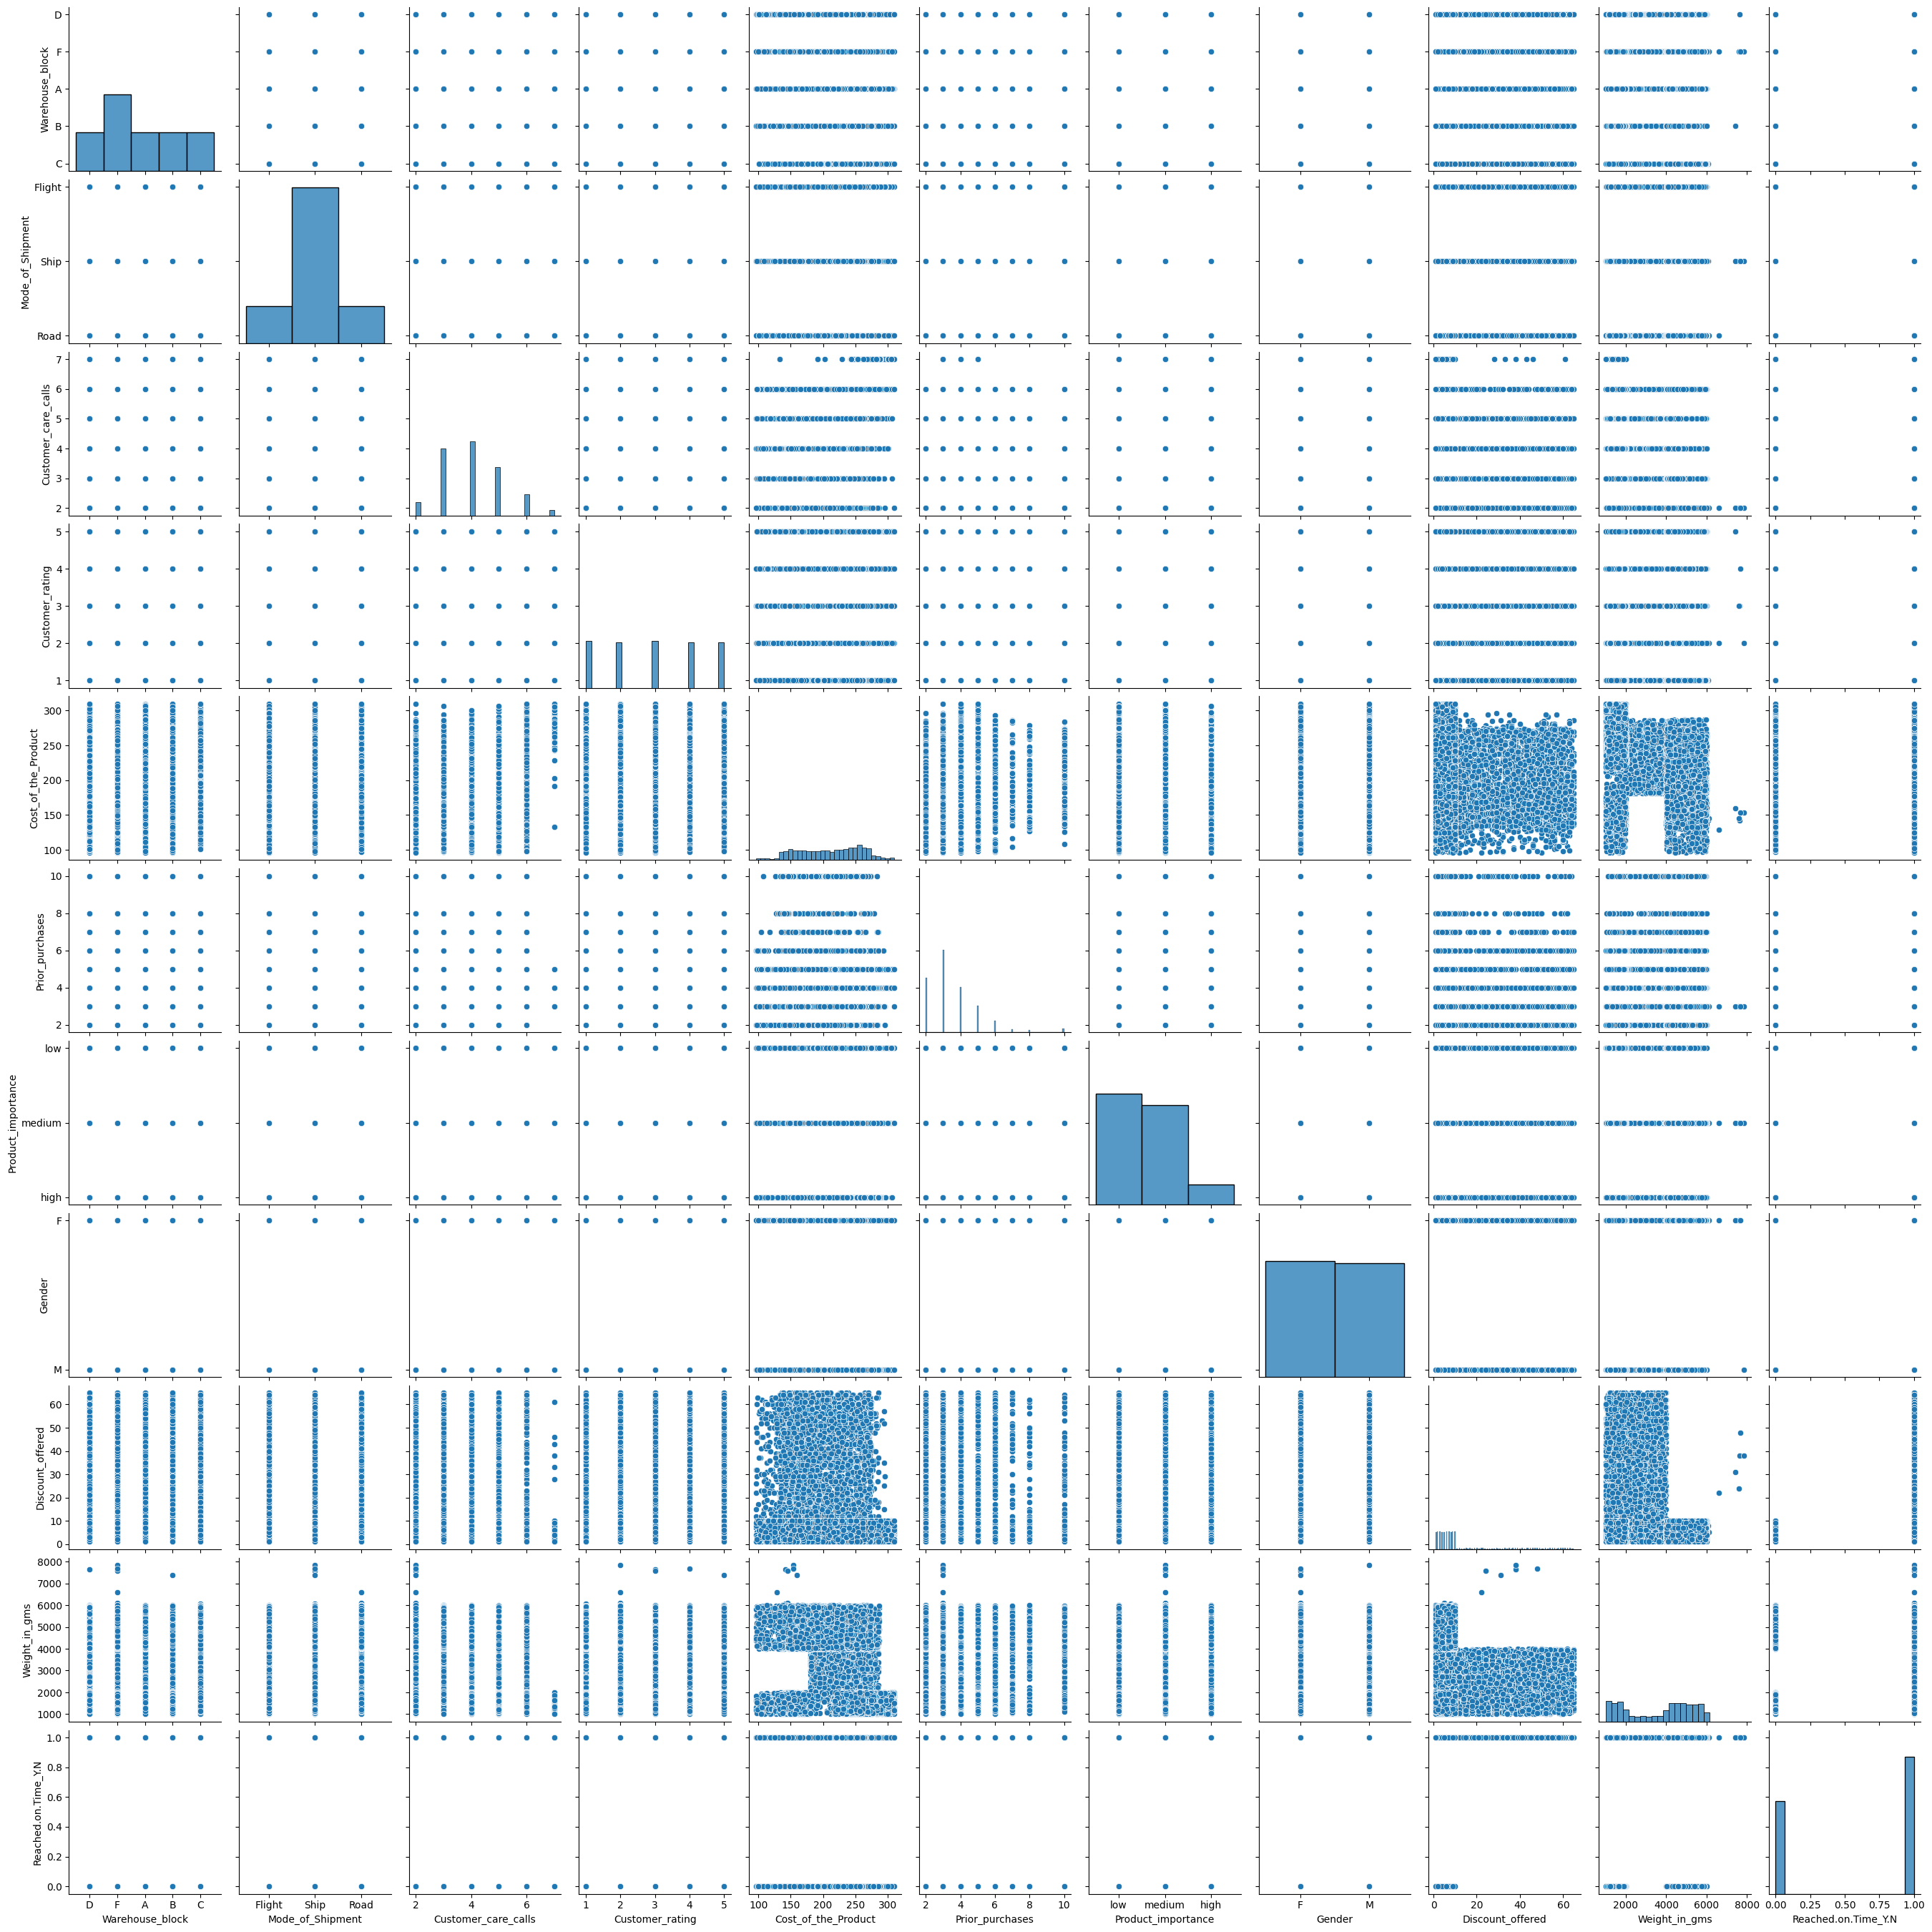

In [9]:
vars = df.columns
sns.pairplot(df, vars=vars)

plt.show()

### Correlation Matrix (One Hot Encoding)

As some variables are categorical and not ordinal one hot encoding was used to look at correlation. Overall this increases the number of variables from 11 to 20 and makes comparisons generally more difficult. 

Comparing the one hot encoded categorical data to variables outside the same category no significant trends appear. Since individual one-hot encoded categorical variables don't show strong trends they will be combined using label encoding and a more detailed analysis will be done on correlations in the next step.

<Axes: >

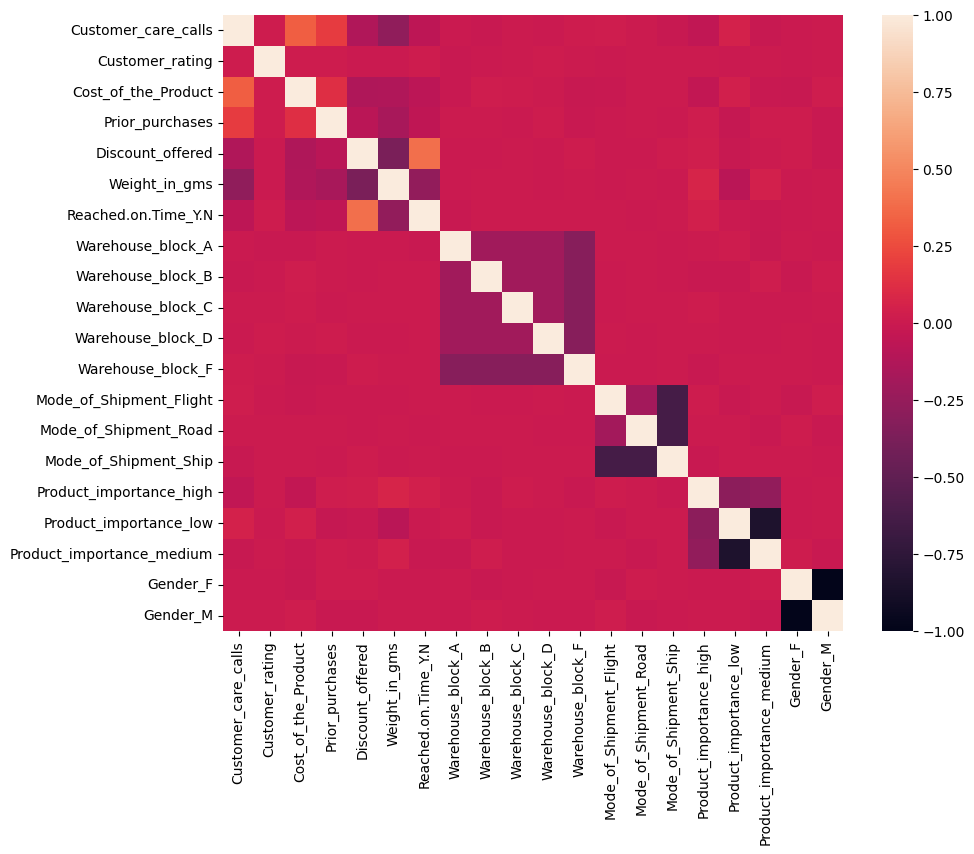

In [10]:
df_one_hot = pd.get_dummies(df)
plt.figure(figsize=(10, 8))
corr_one_hot = df_one_hot.corr()
sns.heatmap(corr_one_hot)

### Correlation Matrix (Label Encoding)

To keep the number of variables smaller label encoding was used to look at overall trends. In general a few significant trends were found. Using +/- 0.20 as an arbitrary cutoff the following correlations were observed:

- Discount Offered vs. Arrive on Time: This was the strongest trend at 0.40, indicating discount offered is going to be an important variable for models to use for preditions.
- Weight in Grams vs. Arrive on Time: Also a strong correlation with the target variable, lower product weights tend to arrive on time more often.
- Discount Offered vs. Weight in Grams: As the weight drops there is less likely to be a discount.
- Weight in Grams vs. Customer Care Calls: Higher weight means less customer care calls.
- Weight in Grams vs. Cost of Product: More heavy products tend to cost more, which intuitively makes sense.

All of these trends will be looked at in a more individual basis in the next section.

In [11]:

le = LabelEncoder()

df_label_encode = df.copy()

categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_label_encode[col] = le.fit_transform(df_label_encode[col])

<Axes: >

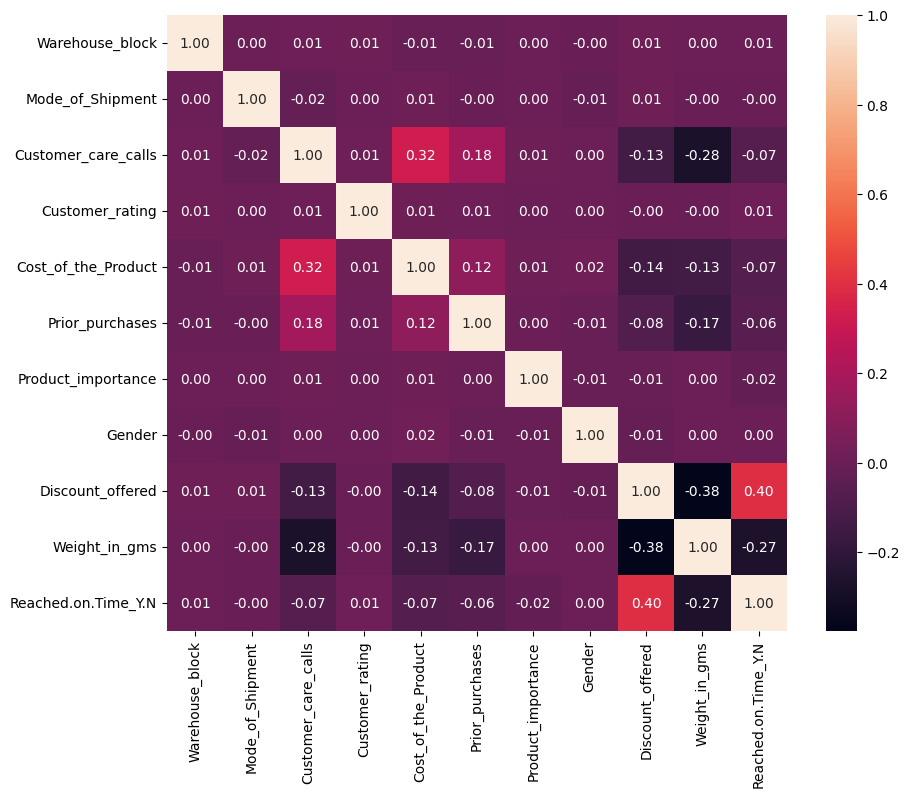

In [12]:
corr_label_encode = df_label_encode.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_label_encode, fmt='.2f', annot=True)

## Individual Correlations

A deeper look at the significant trends between variables.

### Discount Offered vs. Reached on Time

Products with higher discounts are much more likely to arrive on time. 

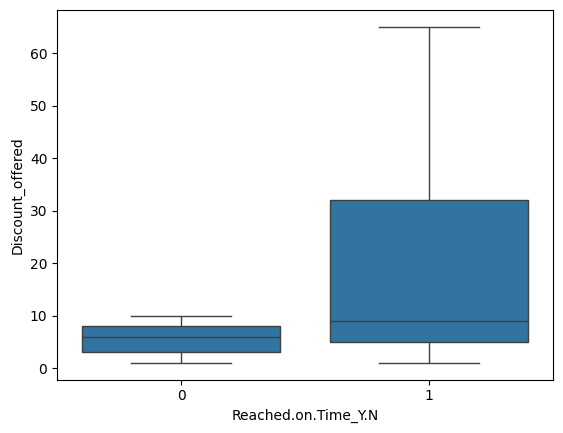

In [13]:
sns.boxplot(x=df[TARGET], y=df['Discount_offered'])
plt.show()

### Weight in Grams vs. Reached on Time

Comparing a boxplot shows the median value for weight of delayed shipments is higher, however there are a large number of low weight outliers, suggesting the data is bi-modal. 

Plotting the density shows that the weight in grams distribution is indeed bi-modal. What stands out is low weight products are more likely to arrive on time, and virtually no products between ~2.5 kg and ~3.5 kg are delayed.

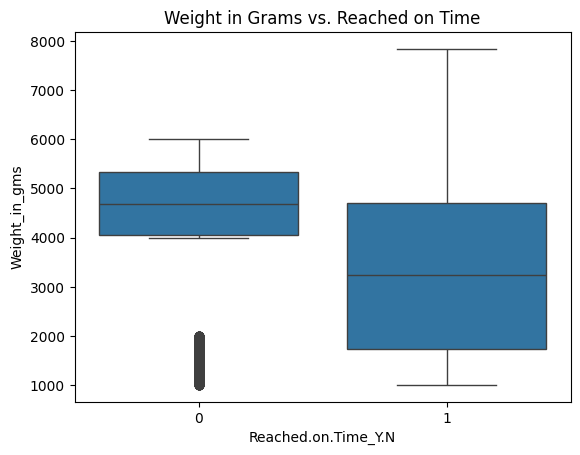

In [14]:
sns.boxplot(x=df[TARGET], y=df['Weight_in_gms'])
plt.title("Weight in Grams vs. Reached on Time")
plt.show()

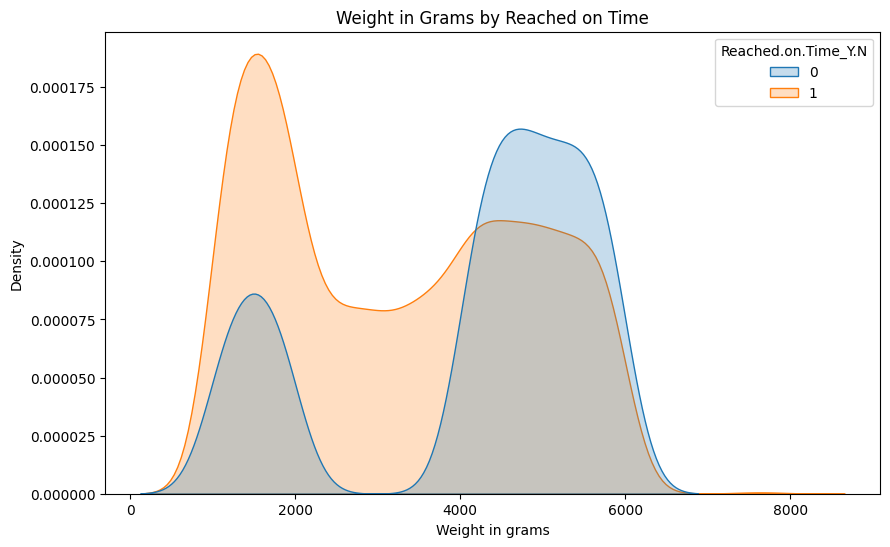

In [15]:
# Plot density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Weight_in_gms', hue=TARGET, fill=True)
plt.title('Weight in Grams by Reached on Time')
plt.xlabel('Weight in grams')
plt.ylabel('Density')
plt.show()

### Discount Offered vs. Weight in Grams

It seems like there are specific ranges for discounts based on weight:
- 1kg - 4kg: 0 - 65 % discount
- 4kg - 6kg: 0 - 10 % discount
- 6kg+ : Very few products and no trend

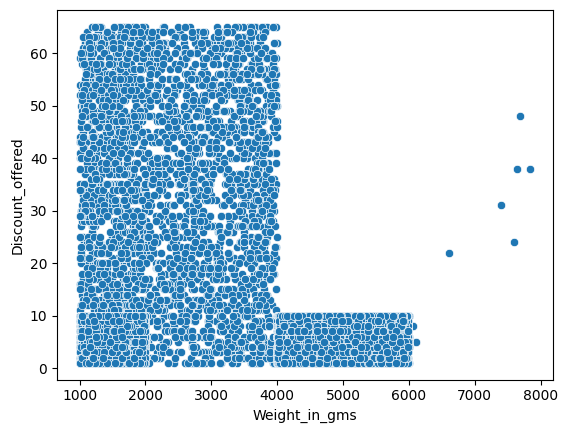

In [16]:
sns.scatterplot(data=df, x='Weight_in_gms', y='Discount_offered')
plt.show()

### Weight in Grams vs. Customer Care Calls

Lighter packages have less customer care calls. This is not expected, as heavier packages are more likely to be delayed.

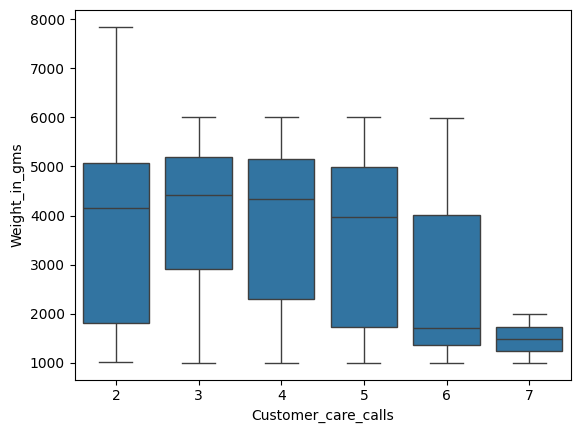

In [17]:
sns.boxplot(data=df, y='Weight_in_gms', x='Customer_care_calls')
plt.show()

### Cost of Product vs. Customer Care Calls

Higher cost products have more customer care calls as expected.

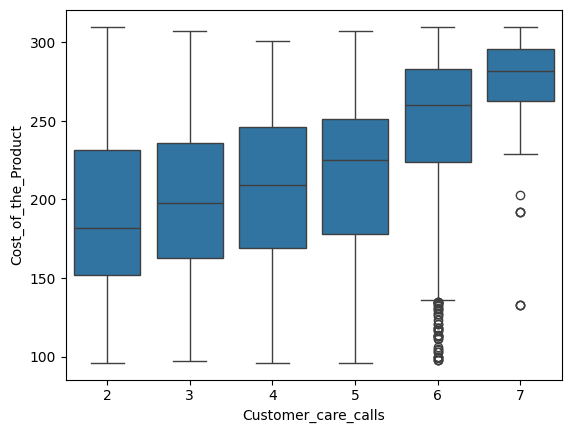

In [18]:
sns.boxplot(data=df, y='Cost_of_the_Product', x='Customer_care_calls')
plt.show()

## Part II: Data Cleaning, Preparation and Feature Engineering

During EDA, it was observed that the dataset was relativey clean and free of missing values.  However, it was also observed that several categorical features were present, which will need to be encoded to make them understandable to the models downstream.  There are also several numerical/continuous variables present, which will require normalization.  With this in mind, the following data preparation tasks will be conducted:

- Drop columns unnecessary for modeling (ie: ID)
- One-Hot encode categorical variables
- Ordinally encode ordinal categorical variables
- Separate target variable from features
- Perform train/test/val split at 80/10/10
- Normalize continuous variables

It should be noted that the normalization scaler was fit to the training dataset only to avoid data leakage.  The trained scaler was then applied to the three resulting data sets: train/test/val

## Setup

### Split X and y features

In [21]:
# separate features from target
X = df.drop(columns=TARGET)
y = df[TARGET]

### Encode Categorical Features

There are several categorical features present in the dataset that must be encoded for use by any downstream models.  These features will be one-hot encoded.  Since Product Importance represents an ordinal feature, this feature will be ordinally encoded with label encoding.


In [22]:
# label encode the product_importance column since it is ordinal
le = LabelEncoder()

X_encoded = X.copy()

categorical_columns = ['Product_importance']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    X_encoded[col] = le.fit_transform(X_encoded[col])

In [23]:
# inspect the results
X_encoded.head()

Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0               D           Flight                    4                2   
1               F           Flight                    4                5   
2               A           Flight                    2                2   
3               B           Flight                    3                3   
4               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases  Product_importance Gender  \
0                  177                3                   1      F   
1                  216                2                   1      M   
2                  183                4                   1      M   
3                  176                4                   2      M   
4                  184                3                   2      F   

   Discount_offered  Weight_in_gms  
0                44           1233  
1                59           3088  
2                48           3374  
3                10           1177  
4                46           2484

In [24]:
# one hot encode the remaining categorical features
X_encoded = pd.get_dummies(X_encoded)

In [25]:
# inspect results
X_encoded.head()

Customer_care_calls  Customer_rating  Cost_of_the_Product  Prior_purchases  \
0                    4                2                  177                3   
1                    4                5                  216                2   
2                    2                2                  183                4   
3                    3                3                  176                4   
4                    2                2                  184                3   

   Product_importance  Discount_offered  Weight_in_gms  Warehouse_block_A  \
0                   1                44           1233                  0   
1                   1                59           3088                  0   
2                   1                48           3374                  1   
3                   2                10           1177                  0   
4                   2                46           2484                  0   

   Warehouse_block_B  Warehouse_block_C  Warehouse_block_D  Warehouse_block_F  \
0                  0                  0                  1                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  1                  0                  0                  0   
4                  0                  1                  0                  0   

   Mode_of_Shipment_Flight  Mode_of_Shipment_Road  Mode_of_Shipment_Ship  \
0                        1                      0                      0   
1                        1                      0                      0   
2                        1                      0                      0   
3                        1                      0                      0   
4                        1                      0                      0   

   Gender_F  Gender_M  
0         1         0  
1         0         1  
2         0         1  
3         0         1  
4         1         0

### Perform Train/Test Split

Split the prepared dataset into train/test/val datasets for use by modeling in next stages.  Implement an 80/10/10 split.

In [26]:
# split the data into train and test sets (80% and 20%)
X_train, X_test_val, y_train, y_test_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# split the test_val into test and val sets (10% and 10%)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

### Normalize Continuous Numerical Features

For the remaining continuous features, a scaler will be fit to the dataset to normalize the numerical range

In [27]:
#list for cols to scale
cols_to_scale = ['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms', 'Prior_purchases', 'Customer_care_calls']

#create and fit scaler using X train set
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

#scale X train, test, val data
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

### Write prepared data to file for use by modeling experiments

In [28]:
# train data
X_train.to_csv('./data/x_train.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)

# test data
X_test.to_csv('./data/x_test.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

# val data
X_val.to_csv('./data/x_val.csv', index=False)
y_val.to_csv('./data/y_val.csv', index=False)

## Part III-A: Modeling - Logistic Regression, KNN, RandomForest

## Load Preprocessed Data

Note: This is only done once for the first model and used throughout the notebook.

In [31]:
# train data
X_train = pd.read_csv('./data/x_train.csv')
y_train = np.ravel(pd.read_csv('./data/y_train.csv'))

# val data
X_val = pd.read_csv('./data/x_val.csv')
y_val = np.ravel(pd.read_csv('./data/y_val.csv'))

In [32]:
# Check imported data
print('TRAIN SET:')
print('   X_train:', X_train.shape)
print('   y_train:', y_train.shape)
print('\nVALIDATION SET:')
print('   X_val:', X_val.shape)
print('   y_val:', y_val.shape)

TRAIN SET:
   X_train: (8799, 17)
   y_train: (8799,)

VALIDATION SET:
   X_val: (1100, 17)
   y_val: (1100,)


In [33]:
X_train.head()

Customer_care_calls  Customer_rating  Cost_of_the_Product  Prior_purchases  \
0            -0.925605                5            -0.670120        -0.378680   
1             1.697108                3            -0.173246         0.273631   
2            -1.799843                5             1.379486        -0.378680   
3             0.822870                5             0.178707        -1.030992   
4             1.697108                3             1.772845         0.273631   

   Product_importance  Discount_offered  Weight_in_gms  Warehouse_block_A  \
0                   1         -0.392911       0.311901                  0   
1                   2         -0.638968       0.532606                  1   
2                   2         -0.454426      -1.585178                  0   
3                   2         -0.577454       0.406052                  0   
4                   1         -0.577454      -1.207352                  0   

   Warehouse_block_B  Warehouse_block_C  Warehouse_block_D  Warehouse_block_F  \
0                  0                  0                  0                  1   
1                  0                  0                  0                  0   
2                  0                  0                  1                  0   
3                  0                  1                  0                  0   
4                  0                  1                  0                  0   

   Mode_of_Shipment_Flight  Mode_of_Shipment_Road  Mode_of_Shipment_Ship  \
0                        0                      0                      1   
1                        0                      0                      1   
2                        0                      0                      1   
3                        0                      0                      1   
4                        1                      0                      0   

   Gender_F  Gender_M  
0         1         0  
1         1         0  
2         0         1  
3         0         1  
4         1         0

In [34]:
X_val.head()

Customer_care_calls  Customer_rating  Cost_of_the_Product  Prior_purchases  \
0            -0.051367                2             1.213861        -1.030992   
1            -0.051367                2            -0.421683        -0.378680   
2            -0.051367                1            -0.297464        -1.030992   
3            -0.925605                3            -0.152543        -0.378680   
4             0.822870                5             0.779096         0.925943   

   Product_importance  Discount_offered  Weight_in_gms  Warehouse_block_A  \
0                   2         -0.700483       0.237314                  0   
1                   2         -0.392911       0.697675                  1   
2                   1         -0.638968       0.689116                  0   
3                   2         -0.392911       0.826674                  0   
4                   2         -0.331397      -1.066126                  1   

   Warehouse_block_B  Warehouse_block_C  Warehouse_block_D  Warehouse_block_F  \
0                  0                  0                  1                  0   
1                  0                  0                  0                  0   
2                  0                  0                  1                  0   
3                  0                  0                  1                  0   
4                  0                  0                  0                  0   

   Mode_of_Shipment_Flight  Mode_of_Shipment_Road  Mode_of_Shipment_Ship  \
0                        0                      1                      0   
1                        0                      1                      0   
2                        0                      0                      1   
3                        1                      0                      0   
4                        1                      0                      0   

   Gender_F  Gender_M  
0         1         0  
1         0         1  
2         0         1  
3         0         1  
4         0         1

## Model 1: Logistic Regression

A simple Logistic Regression is used to establish a baseline performance. 
Default parameter values are used.

### Model 1: Create, Train Model

In [35]:
# create model instance
model1 = []
model1 = LogisticRegression(solver='liblinear', random_state=0)

#fit the model using the training data
model1.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

### Model 1: Describe/Visualize Model

In [36]:
model1_featcoeff = pd.DataFrame({ 'features': model1.feature_names_in_,
                                  'coef' : np.ravel(model1.coef_)})

model1_featcoeff.set_index('features').sort_values('coef')

coef
features                         
Weight_in_gms           -0.380287
Customer_care_calls     -0.127812
Prior_purchases         -0.122080
Cost_of_the_Product     -0.109246
Product_importance      -0.096254
Customer_rating          0.022963
Warehouse_block_A        0.027294
Warehouse_block_D        0.091684
Warehouse_block_F        0.099142
Warehouse_block_C        0.133640
Warehouse_block_B        0.138702
Mode_of_Shipment_Road    0.142091
Mode_of_Shipment_Ship    0.160484
Mode_of_Shipment_Flight  0.187887
Gender_F                 0.224526
Gender_M                 0.265936
Discount_offered         1.787787

Holding other features constant, **Discount_offered** contributes the most to timely arrival of shipments while **Weight_in_gms** contributes the most to late arrival. This is consistent with our EDA analysis (section 'General Correlation between Variables')

### Model 1: Performance on Validation Set

In [37]:
# predict y values based on the validation set
y_pred1 = model1.predict(X_val)

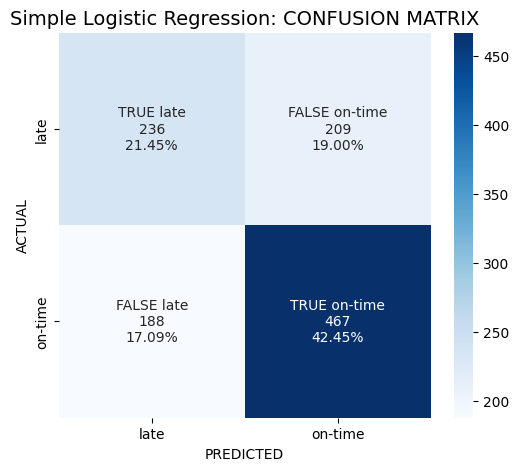

In [38]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'Simple Logistic Regression')

In [39]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'Simple Logistic Regression')
    

Simple Logistic Regression: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.53      0.54       445
     on-time       0.69      0.71      0.70       655

    accuracy                           0.64      1100
   macro avg       0.62      0.62      0.62      1100
weighted avg       0.64      0.64      0.64      1100



## Model 2: K Nearest Neighbor

....

### Model 2: Create, train, evaluate as many KNN models as there are K-values

In [41]:
k_values = list(range(1, 20))
acc_train = []
acc_val = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    y_pred_train = knn.predict(X_train)
    
    y_pred_val = knn.predict(X_val)
    
    acc_train.append(accuracy_score(y_train, y_pred_train))
    acc_val.append(accuracy_score(y_val, y_pred_val))

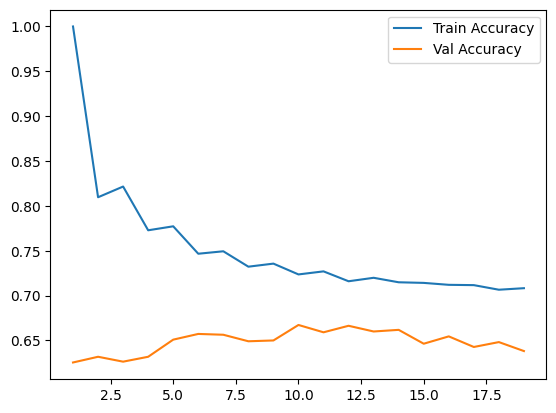

In [42]:
plt.plot(k_values, acc_train, label = 'Train Accuracy')
plt.plot(k_values, acc_val, label = 'Val Accuracy')
plt.legend()


In [43]:
# select k_value with highest Validation accuracy

k_best = acc_val.index(max(acc_val))
k_best

9

In [44]:
# select another k_value with least overfitting
delta = np.subtract(acc_train, acc_val)
k_best2 = delta.argmin()
k_best2

11

In [45]:
# generate kNN model (again) using n_neighbors that gave the highest validation accuraxy

model2 = KNeighborsClassifier(n_neighbors=k_best)
    
model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

### Model 2: Performance on Validation Set

In [46]:
# predict y values based on the validation set
y_pred2 = model2.predict(X_val)

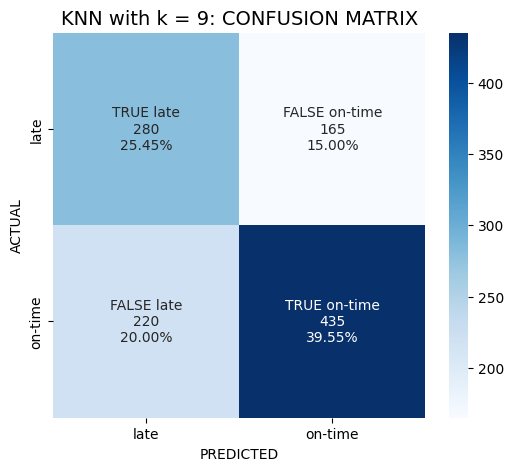

In [47]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = f'KNN with k = {k_best}')

In [48]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = f'KNN with k = {k_best}')

KNN with k = 9: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.63      0.59       445
     on-time       0.72      0.66      0.69       655

    accuracy                           0.65      1100
   macro avg       0.64      0.65      0.64      1100
weighted avg       0.66      0.65      0.65      1100



In [49]:
# tuning
# initialize model
model2_tune = KNeighborsClassifier()

# setup search grid
k_values = list(range(1, 20))

param2_grid = { 
    'n_neighbors' : k_values,
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 20, 40, 10, 50]
}


In [50]:
# run search
CV_knn = GridSearchCV(estimator=model2_tune, param_grid=param2_grid, cv=5, verbose=1, n_jobs=-1)
CV_knn.fit(X_train, y_train)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 20, 40, 10, 50],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             verbose=1)

In [51]:
# display best found hyperparamater combination
CV_knn.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 19}

In [52]:
# get best model
model2_tune_best = CV_knn.best_estimator_

In [53]:
# predict y values based on the validation set using best model
y_pred2_tuned = model2_tune_best.predict(X_val)

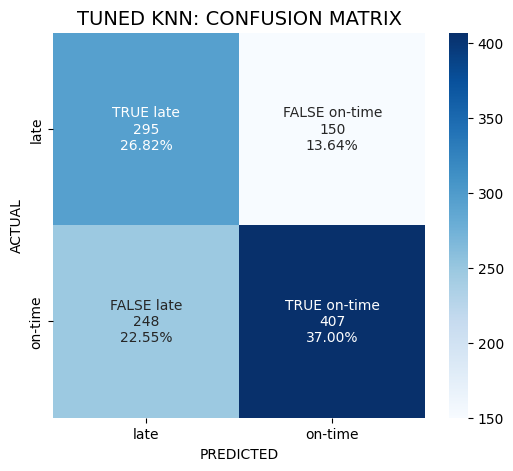

In [54]:
# generate confusion matrix for tuned model 2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title ='TUNED KNN')

In [55]:
# Generate Classification Report for tuned model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'TUNED KNN')

TUNED KNN: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.66      0.60       445
     on-time       0.73      0.62      0.67       655

    accuracy                           0.64      1100
   macro avg       0.64      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100



## Model 3: Random Forest

....

### Model 3: Create, train, etc

In [57]:
model3 = RandomForestClassifier(max_depth=3, random_state=0)
model3.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [58]:
# predict y values based on the validation set
y_pred3 = model3.predict(X_val)

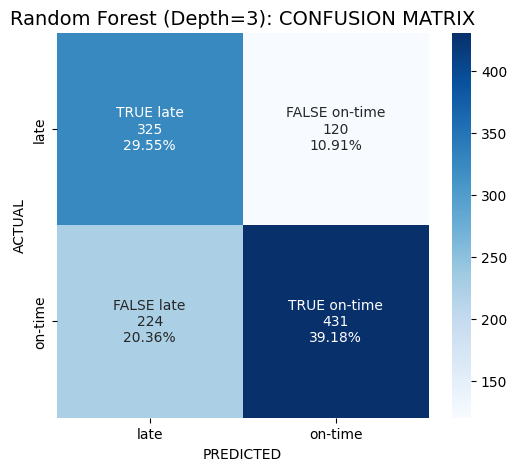

In [59]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3, title = 'Random Forest (Depth=3)')

In [60]:
# Generate Classification Report for model 3
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3, title = 'Random Forest (Depth=3)')

Random Forest (Depth=3): CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.59      0.73      0.65       445
     on-time       0.78      0.66      0.71       655

    accuracy                           0.69      1100
   macro avg       0.69      0.69      0.68      1100
weighted avg       0.71      0.69      0.69      1100



In [61]:
#hyper parameter tuning

# initialize model
model3_tune = RandomForestClassifier(random_state=0)

# setup search grid
param_grid = { 
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [2, 3, 4, 5, 7],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [62]:
# run search
CV_rf = GridSearchCV(estimator=model3_tune, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
CV_rf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 7]},
             verbose=1)

In [63]:
# display best found hyperparamater combination
CV_rf.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4}

In [64]:
# get best model
model3_tune_best = CV_rf.best_estimator_

In [65]:
# predict y values based on the validation set using best model
y_pred3_tuned = model3_tune_best.predict(X_val)

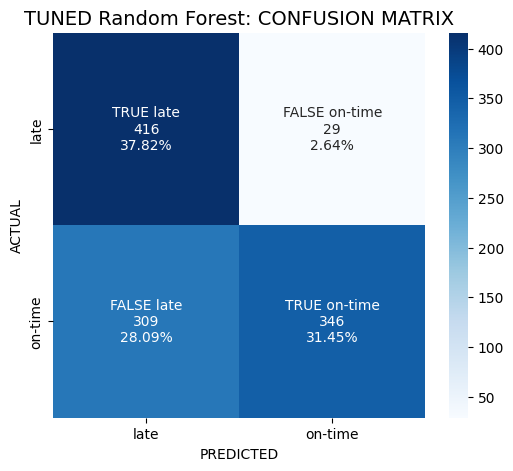

In [66]:
# generate confusion matrix for tuned model 3
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title ='TUNED Random Forest')

In [67]:
# Generate Classification Report for tuned model 3
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'TUNED Random Forest')

TUNED Random Forest: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.93      0.71       445
     on-time       0.92      0.53      0.67       655

    accuracy                           0.69      1100
   macro avg       0.75      0.73      0.69      1100
weighted avg       0.78      0.69      0.69      1100



TUNED Random Forest (TEST DATA): CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.92      0.71       450
     on-time       0.91      0.53      0.67       650

    accuracy                           0.69      1100
   macro avg       0.74      0.73      0.69      1100
weighted avg       0.77      0.69      0.68      1100



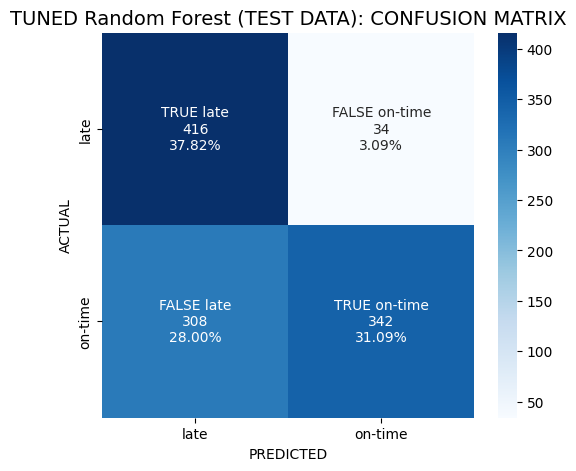

In [68]:
# test data
X_test = pd.read_csv('./data/x_test.csv')
y_test = np.ravel(pd.read_csv('./data/y_test.csv'))

# predict y values based on the validation set using best model
y_pred3_tuned_test = model3_tune_best.predict(X_test)

# generate confusion matrix for tuned model 3
aai510_grp7_confusion_matrix(y_true = y_test, y_pred = y_pred3_tuned_test, title ='TUNED Random Forest (TEST DATA)')

# Generate Classification Report for tuned model 3
aai510_grp7_class_report(y_true = y_test, y_pred = y_pred3_tuned_test, title = 'TUNED Random Forest (TEST DATA)')

## Part III-B: Modeling - Naive Bayes Classifier, Support Vector Machine

## Model 1: Naive Bayes Classifier

Naive bayes classifier to predict on-time shipments.

### Naive Bayes Classifier Baseline - No Tuning

In [75]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

GaussianNB()

### Model 1: Performance on Validation Set

In [76]:
# predict y values based on the validation set
y_pred1 = gnb_model.predict(X_val)

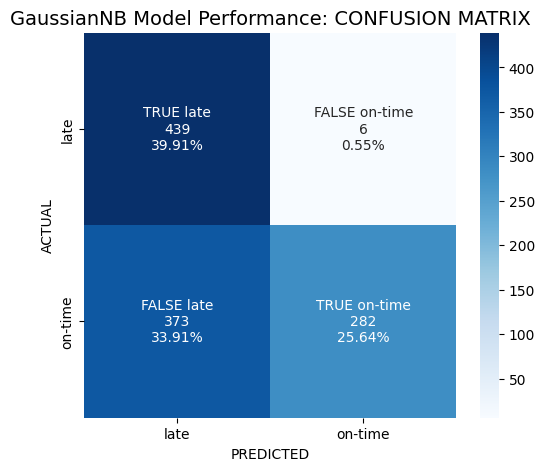

In [77]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'GaussianNB Model Performance')

In [78]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'GaussianNB')
    

GaussianNB: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.99      0.70       445
     on-time       0.98      0.43      0.60       655

    accuracy                           0.66      1100
   macro avg       0.76      0.71      0.65      1100
weighted avg       0.80      0.66      0.64      1100



### Naive Bayes Classifier - Tuning

In [79]:
gnb_model_tune = GaussianNB()

In [80]:
# Define the parameter grid
gnb_param_grid = {
    'var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]  # Smoothing parameter
}

In [81]:
gnb_grid_search = GridSearchCV(estimator=gnb_model_tune, param_grid=gnb_param_grid, scoring='accuracy', verbose=1, n_jobs=-1)

In [82]:
gnb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                           1e-08, 1e-09, 1e-10, 1e-11]},
             scoring='accuracy', verbose=1)

In [83]:
# Print the best parameters and best score
print("Best Parameters:", gnb_grid_search.best_params_)
print("Best Score:", gnb_grid_search.best_score_)

Best Parameters: {'var_smoothing': 1e-05}
Best Score: 0.6496204584216239


In [84]:
gnb_best_model = gnb_grid_search.best_estimator_
y_pred1_tuned = gnb_best_model.predict(X_val)

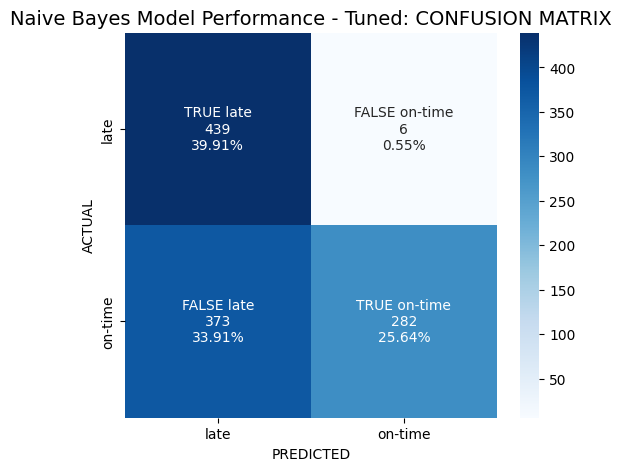

In [85]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1_tuned, title = 'Naive Bayes Model Performance - Tuned')

In [86]:
# Generate Classification Report for model 1 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1_tuned, title = 'Naive Bayes - Tuned Hyperparameters')

Naive Bayes - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.99      0.70       445
     on-time       0.98      0.43      0.60       655

    accuracy                           0.66      1100
   macro avg       0.76      0.71      0.65      1100
weighted avg       0.80      0.66      0.64      1100



## Model 2: Support Vector Machine (SVM)

....

### Model 2: SVC Baseline - No Tuning

In [87]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### Model 2: Performance on Validation Set

In [88]:
# predict y values based on the validation set
y_pred2 = svm_model.predict(X_val)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

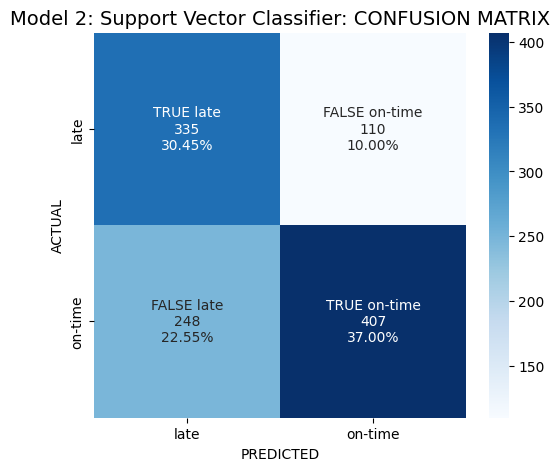

In [89]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = 'Model 2: Support Vector Classifier')

In [90]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = 'Model 2: Support Vector Classifier')

Model 2: Support Vector Classifier: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.75      0.65       445
     on-time       0.79      0.62      0.69       655

    accuracy                           0.67      1100
   macro avg       0.68      0.69      0.67      1100
weighted avg       0.70      0.67      0.68      1100



### SVC Tuning

In [91]:
svc_model_tune = SVC()

In [92]:
svc_param_grid = {
    'C': [0.01, .1, 1, 10],   # Regularization: Low C = high bias, low variance
    'gamma': [0.001, 0.01, 0.1, 1],  # High means focusing more on points close to decision boundary, low is smoother boundary
    'kernel': ['linear', 'rbf']   # Kernel type: Linear good for simple linearly seperable, otherwise radial basis function
}

In [93]:
svc_grid_search = GridSearchCV(estimator=svc_model_tune, param_grid=svc_param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
svc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [94]:
# Print the best parameters and best score
print("Best Parameters:", svc_grid_search.best_params_)
print("Best Score:", svc_grid_search.best_score_)

Best Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.6633724611091012


In [95]:
svc_best_model = svc_grid_search.best_estimator_
y_pred2_tuned = svc_best_model.predict(X_val)

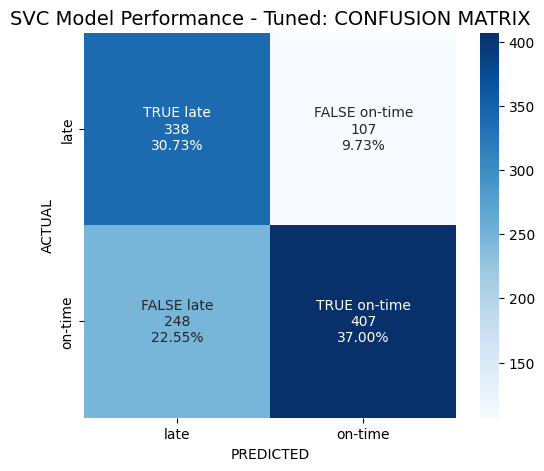

In [96]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title = 'SVC Model Performance - Tuned')

In [97]:
# Generate Classification Report for model 2 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'Support Vector Classifier - Tuned Hyperparameters')

Support Vector Classifier - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.58      0.76      0.66       445
     on-time       0.79      0.62      0.70       655

    accuracy                           0.68      1100
   macro avg       0.68      0.69      0.68      1100
weighted avg       0.70      0.68      0.68      1100



### SVC Tuning Set 2

In [98]:
svc_model_tune_2 = SVC()

In [99]:
svc_param_grid_2 = {
    'C': [0.02, 0.05, .1, 0.2, 0.5],   # Regularization: Low C = high bias, low variance
    'gamma': [0.002, 0.005, 0.01, 0.02, 0.05],  # High means focusing more on points close to decision boundary, low is smoother boundary
    'kernel': ['rbf']   # Kernel type: Linear good for simple linearly seperable, otherwise radial basis function
}

In [100]:
svc_grid_search_2 = GridSearchCV(estimator=svc_model_tune_2, param_grid=svc_param_grid_2, scoring='accuracy', verbose=1, n_jobs=-1)
svc_grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.02, 0.05, 0.1, 0.2, 0.5],
                         'gamma': [0.002, 0.005, 0.01, 0.02, 0.05],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [101]:
# Print the best parameters and best score
print("Best Parameters:", svc_grid_search_2.best_params_)
print("Best Score:", svc_grid_search_2.best_score_)

Best Parameters: {'C': 0.05, 'gamma': 0.02, 'kernel': 'rbf'}
Best Score: 0.6642816166210139


In [102]:
svc_best_model_2 = svc_grid_search_2.best_estimator_
y_pred3_tuned = svc_best_model_2.predict(X_val)

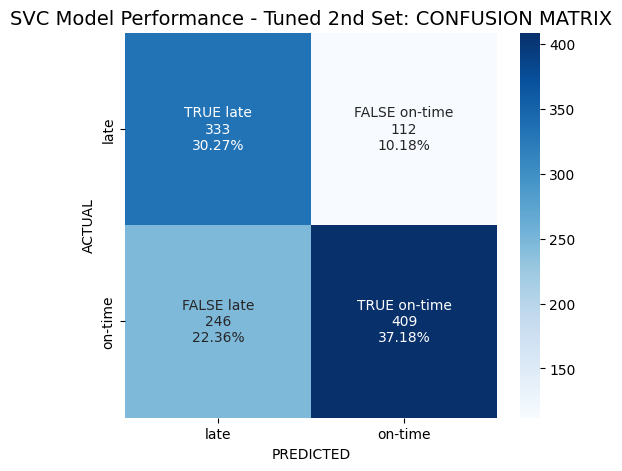

In [103]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title = 'SVC Model Performance - Tuned 2nd Set')

In [104]:
# Generate Classification Report for model 3 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'Support Vector Classifier - Tuned Hyperparameters 2nd Set')

Support Vector Classifier - Tuned Hyperparameters 2nd Set: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.58      0.75      0.65       445
     on-time       0.79      0.62      0.70       655

    accuracy                           0.67      1100
   macro avg       0.68      0.69      0.67      1100
weighted avg       0.70      0.67      0.68      1100



## Part III-C: Modeling - Decision Tree, XGBoost

## Model 1: Decision Tree Classifier

Decision Tree classifier to predict on-time shipments.

### Model 1: Create, Train Model

Start with some standard hyperparameters to initialize the model as a baseline

In [113]:
# Decision Tree helper functions
def plot_feature_importance(dt, columns):
    feat_importance = dt.tree_.compute_feature_importances(normalize=False)
    #feat_importance_df = pd.DataFrame(feat_importance.reshape(1,-1), columns=list(X_train))
    feat_importance_df = pd.Series(feat_importance, index=columns)

    # plot feature importances
    fig, ax = plt.subplots(figsize=(18, 6))
    feat_importance_df.plot.bar(ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Importance")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [114]:
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, criterion='entropy')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)

### Model 1: Describe/Visualize Model

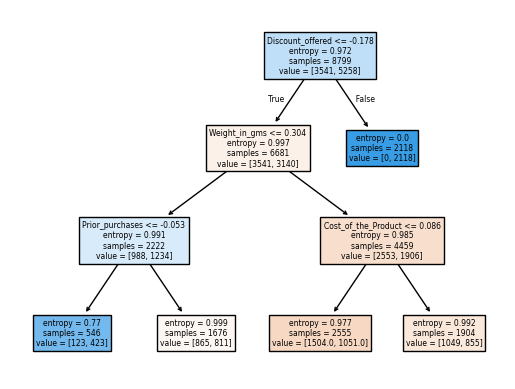

In [115]:
# visualize the tree generated
f_names=list(X_train.columns) 
tree.plot_tree(dt_model, filled=True, feature_names=f_names) 
plt.show() 

### Model 1: Performance on Validation Set

In [116]:
# predict y values based on the validation set
y_pred1 = dt_model.predict(X_val)

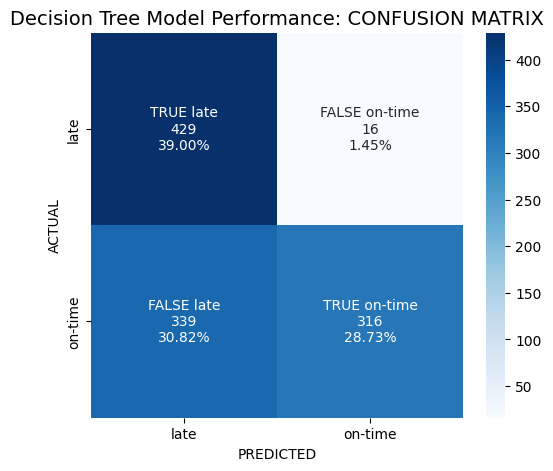

In [117]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree Model Performance')

In [118]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree')
    

Decision Tree: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.96      0.71       445
     on-time       0.95      0.48      0.64       655

    accuracy                           0.68      1100
   macro avg       0.76      0.72      0.67      1100
weighted avg       0.79      0.68      0.67      1100



### Model 1: Evaluate Feature Importance

Extract and visualize feature importance for the tree.  Determine if there are any insights to extract that may help optimize the dataset or model.

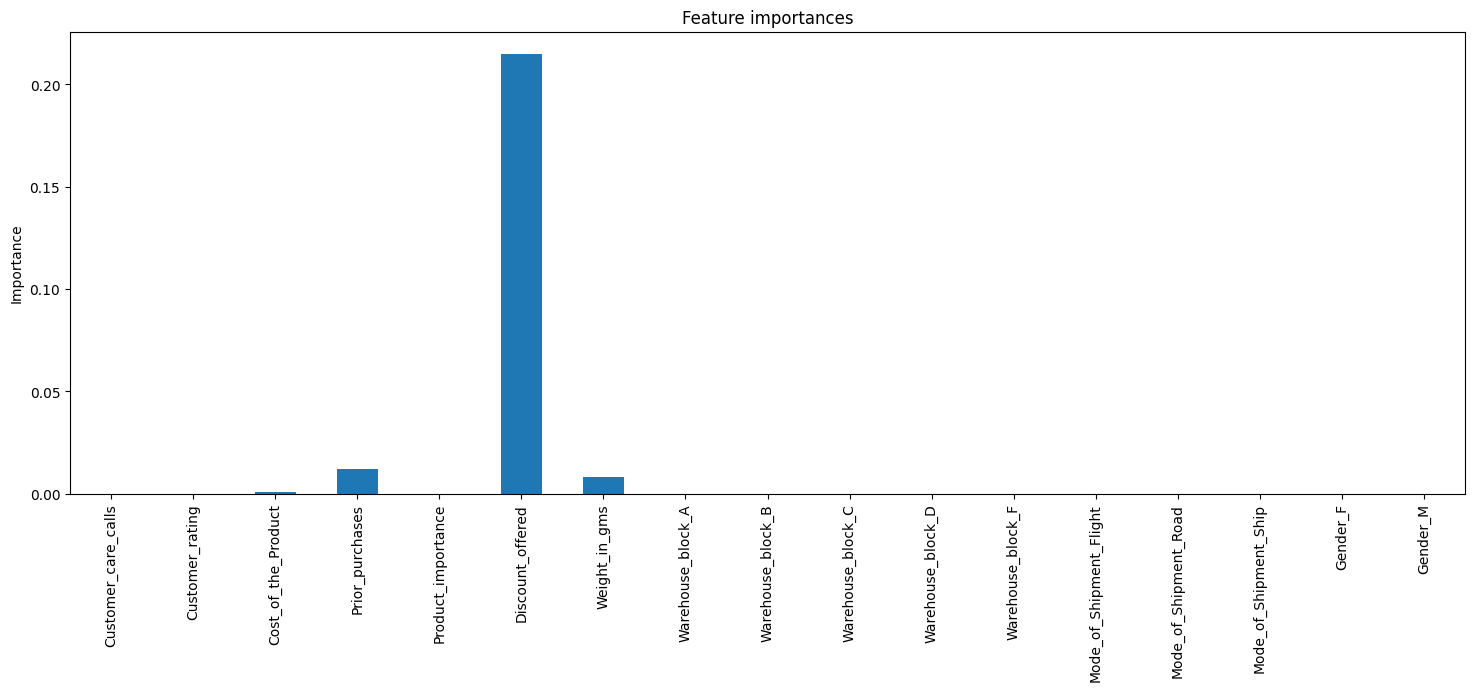

In [119]:
# plot feature importances 
plot_feature_importance(dt_model, X_train.columns)

### Model 1: Hyperparameter Tuning

Perform random search to optimize hyperparameters

In [120]:
# initialize new model
dt_model_tune= DecisionTreeClassifier(random_state=42)

In [121]:
# setup search grid
param_grid = { 
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [2, 3, 4, 5, 7],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [122]:
# run search
CV_dtc = GridSearchCV(estimator=dt_model_tune, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
CV_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 7]},
             verbose=1)

In [123]:
# display best found hyperparamater combination
CV_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

In [124]:
# get best model
dt_model_best = CV_dtc.best_estimator_

In [125]:
# predict y values based on the validation set using best model
y_pred1_tuned = dt_model_best.predict(X_val)

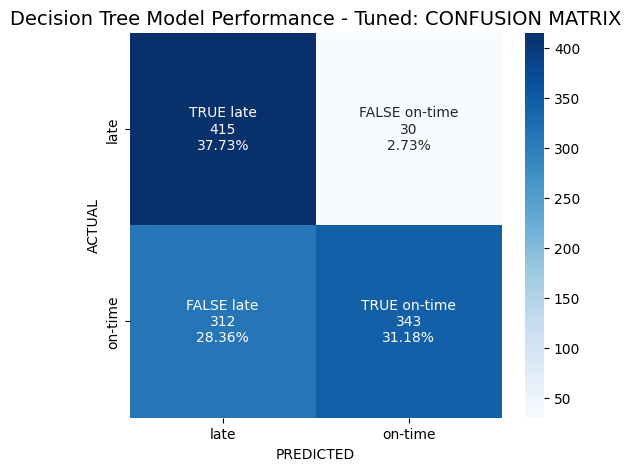

In [126]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree Model Performance - Tuned')

In [127]:
# Generate Classification Report for model 1 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree - Tuned Hyperparameters')

Decision Tree - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.93      0.71       445
     on-time       0.92      0.52      0.67       655

    accuracy                           0.69      1100
   macro avg       0.75      0.73      0.69      1100
weighted avg       0.78      0.69      0.68      1100



## Model 2: XGBoost

....

### Model 2: Create, train, evaluate

In [128]:
# fit the baseline model
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

### Model 2: Performance on Validation Set

In [129]:
# predict y values based on the validation set
y_pred2 = xgb1.predict(X_val)

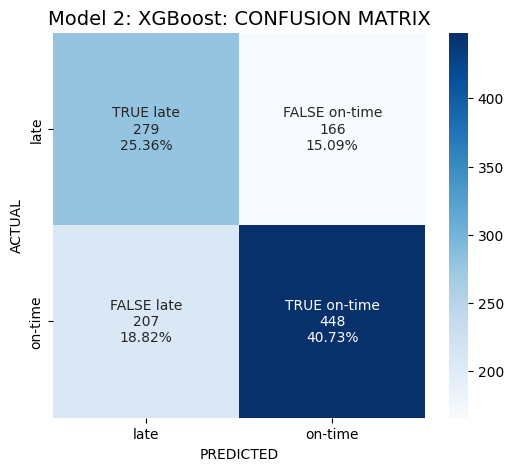

In [130]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost')

In [131]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost Classifier')

Model 2: XGBoost Classifier: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.63      0.60       445
     on-time       0.73      0.68      0.71       655

    accuracy                           0.66      1100
   macro avg       0.65      0.66      0.65      1100
weighted avg       0.67      0.66      0.66      1100



### Hyperparameter Tuning XGBoost

In [132]:
# fit the baseline model
xgb1_tuned = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [133]:
# setup search grid
param_grid_xg = { 
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6,8,10,12],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [134]:
# run search
CV_xgc = GridSearchCV(estimator=xgb1_tuned, param_grid=param_grid_xg, cv=5, verbose=1, n_jobs=-1)
CV_xgc.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


KeyboardInterrupt: 

In [ ]:
# display best found hyperparamater combination
CV_xgc.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 12,
 'subsample': 0.8}

In [ ]:
# get best model
xgc_model_best = CV_xgc.best_estimator_

In [ ]:
# predict y values based on the validation set using best model
y_pred2_tuned = xgc_model_best.predict(X_val)

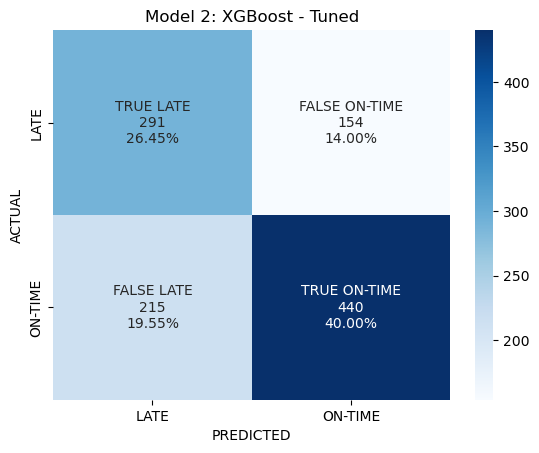

In [ ]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title = 'Model 2: XGBoost - Tuned')

In [ ]:
# Generate Classification Report for Tuned XGBoost
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'Model 2: XGBoost Classifier - Tuned')

              precision    recall  f1-score   support

        LATE       0.58      0.65      0.61       445
     ON-TIME       0.74      0.67      0.70       655

    accuracy                           0.66      1100
   macro avg       0.66      0.66      0.66      1100
weighted avg       0.67      0.66      0.67      1100



### Second Round of Hyperparameter Tuning

In [136]:
# fit the partially tuned model
xgb2_tuned = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=12,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [137]:
# setup search grid
param_grid_xg_2 = { 
    'n_estimators':[100, 200, 1000],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}

In [138]:
# run search
CV_xgc_2 = GridSearchCV(estimator=xgb2_tuned, param_grid=param_grid_xg_2, cv=5, verbose=1, n_jobs=-1)
CV_xgc_2.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.3,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 1000],
                         'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                         'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05]},
             verbose=1)

In [139]:
# display best found hyperparamater combination
CV_xgc_2.best_params_

{'n_estimators': 100, 'reg_alpha': 0.05, 'reg_lambda': 0.05}

In [140]:
# get best model
xgc_model_best_2 = CV_xgc_2.best_estimator_

In [141]:
# predict y values based on the validation set using best model
y_pred3_tuned = xgc_model_best_2.predict(X_val)

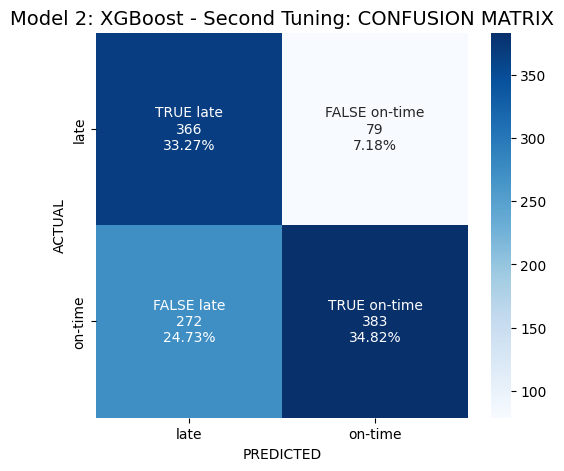

In [142]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title = 'Model 2: XGBoost - Second Tuning')

In [143]:
# Generate Classification Report for Tuned XGBoost
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'Model 2: XGBoost Classifier - Second Tuning')

Model 2: XGBoost Classifier - Second Tuning: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.82      0.68       445
     on-time       0.83      0.58      0.69       655

    accuracy                           0.68      1100
   macro avg       0.70      0.70      0.68      1100
weighted avg       0.73      0.68      0.68      1100

